# HERB LEAF CLASSIFICATION DENGAN MENGGUNAKAN METODE CNN

Anggota Kelompok : 


1.   Dinda Puspa Aprilia - 202010370311261
2.   Muhammad Arvanda Fildza Aliffa Putra - 202010370311285
3.   Prayogi Putra Deluhula - 20081104061

Source Dataset : 
1.   https://data.mendeley.com/datasets/s82j8dh4rr - "Indonesian Herb Leaf Dataset 3500"

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
class_names = ['Belimbing Wuluh', 'Jambu Biji', 'Jeruk Nipis', 'Kemangi', 'Lidah Buaya', 'Nangka', 'Pandan', 'Pepaya', 'Seledri', 'Sirih']
nb_classes = len(class_names)
image_size = (224,224)

In [ ]:
def load_data():

    datasets = ['/content/gdrive/MyDrive/Artificial Intelligence/UAS/Dataset/Herbal Leaf' ]
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['Belimbing Wuluh']: label = 0
            elif folder in ['Jambu Biji']: label = 1
            elif folder in ['Jeruk Nipis']: label = 2
            elif folder in ['Kemangi']: label = 3
            elif folder in ['Lidah Buaya']: label = 4
            elif folder in ['Nangka']: label = 5
            elif folder in ['Pandan']: label = 6
            elif folder in ['Pepaya']: label = 7
            elif folder in ['Seledri']: label = 8
            elif folder in ['Sirih']: label = 9

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [ ]:
images, labels = load_data()

100%|██████████| 350/350 [00:16<00:00, 21.33it/s]


In [ ]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [ ]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))

Number of training examples: 2800
Number of validation examples: 350
Number of testing examples: 350
Training images are of shape: (2800, 224, 224, 3)
Training labels are of shape: (2800,)
Validation images are of shape: (350, 224, 224, 3)
Validation labels are of shape: (350,)
Test images are of shape: (350, 224, 224, 3)
Test labels are of shape: (350,)


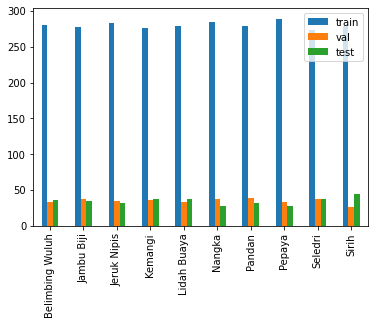

In [ ]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

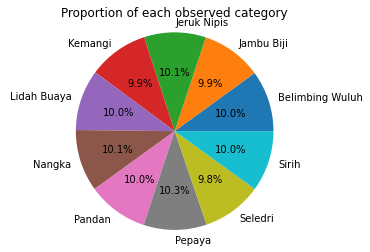

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

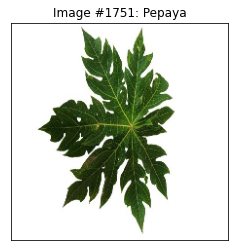

In [ ]:
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

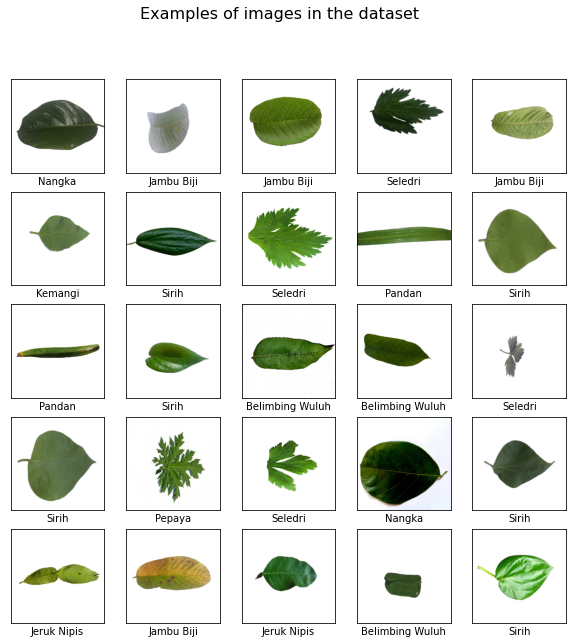

In [ ]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [ ]:
for layer in pre_trained_model.layers:
  print(layer.name)
  layer.trainable = False

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
checkpoint = ModelCheckpoint(filepath='models.h5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=9, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

In [ ]:
history1 = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Epoch 1/10
88/88 [==============================] - 1455s 17s/step - loss: 0.9977 - accuracy: 0.6682 - val_loss: 0.3768 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 1458s 17s/step - loss: 0.3822 - accuracy: 0.8800 - val_loss: 0.2908 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 1448s 16s/step - loss: 0.2714 - accuracy: 0.9146 - val_loss: 0.1966 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 1439s 16s/step - loss: 0.2087 - accuracy: 0.9325 - val_loss: 0.1804 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 1438s 16s/step - loss: 0.1881 - accuracy: 0.9407 - val_loss: 0.1890 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 6/10
88/88 [==============================] - 1444s 16s/step - loss: 0.1570 - accuracy: 0.9514 - val_loss: 0.1381 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 7/10
88/88 [==============================] - 1431s 16s/st

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

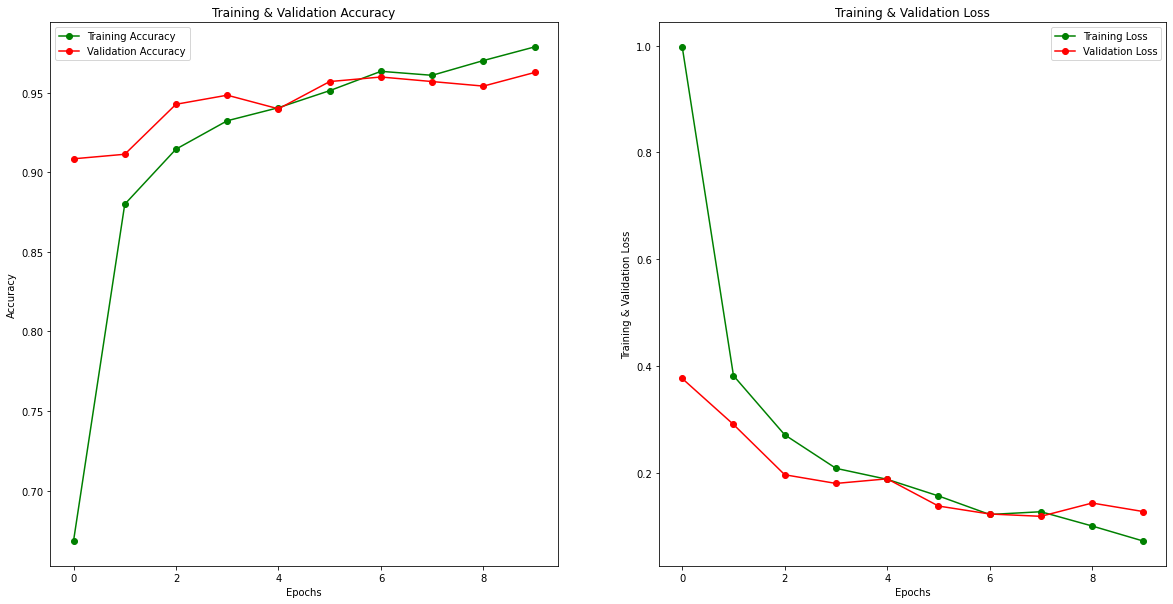

In [ ]:
plot_accuracy_loss_chart(history1)

In [ ]:
results = model.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

11/11 [==============================] - 160s 15s/step - loss: 0.0662 - accuracy: 0.9800
Loss of the model is -  0.06622309237718582
Accuracy of the model is -  98.00000190734863 %


In [ ]:
model.save('/content/gdrive/MyDrive/Artificial Intelligence/UAS/herbal_leaf_models_vgg16.h5')

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

11/11 [==============================] - 163s 15s/step


array([1, 0, 2, 8, 0, 4, 7, 3, 6, 4, 4, 1, 4, 4, 8])

In [ ]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['Belimbing Wuluh (Class 0)', 'Jambu Biji (Class 1)', 'Jeruk Nipis (Class 2)', 'Kemangi (Class 3)', 'Lidah Buaya (Class 4)', 'Nangka (Class 5)', 'Pandan (Class 6)', 'Pepaya (Class 7)', 'Seledri (Class 8)', 'Sirih (Class 9)']))

                           precision    recall  f1-score   support

Belimbing Wuluh (Class 0)       1.00      0.94      0.97        36
     Jambu Biji (Class 1)       1.00      0.97      0.99        35
    Jeruk Nipis (Class 2)       0.97      1.00      0.98        32
        Kemangi (Class 3)       0.93      1.00      0.96        38
    Lidah Buaya (Class 4)       1.00      1.00      1.00        38
         Nangka (Class 5)       1.00      0.96      0.98        28
         Pandan (Class 6)       0.97      1.00      0.98        32
         Pepaya (Class 7)       1.00      1.00      1.00        28
        Seledri (Class 8)       1.00      1.00      1.00        38
          Sirih (Class 9)       0.95      0.93      0.94        45

                 accuracy                           0.98       350
                macro avg       0.98      0.98      0.98       350
             weighted avg       0.98      0.98      0.98       350



In [ ]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
cm

,0,1,2,3,4,5,6,7,8,9
0,34,0,1,0,0,0,0,0,0,1
1,0,34,0,1,0,0,0,0,0,0
2,0,0,32,0,0,0,0,0,0,0
3,0,0,0,38,0,0,0,0,0,0
4,0,0,0,0,38,0,0,0,0,0
5,0,0,0,0,0,27,0,0,0,1
6,0,0,0,0,0,0,32,0,0,0
7,0,0,0,0,0,0,0,28,0,0
8,0,0,0,0,0,0,0,0,38,0
9,0,0,0,2,0,0,1,0,0,42


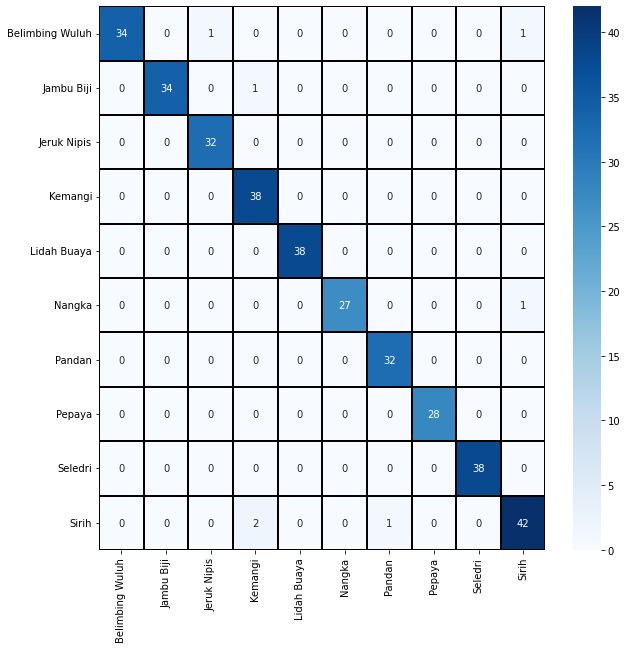

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

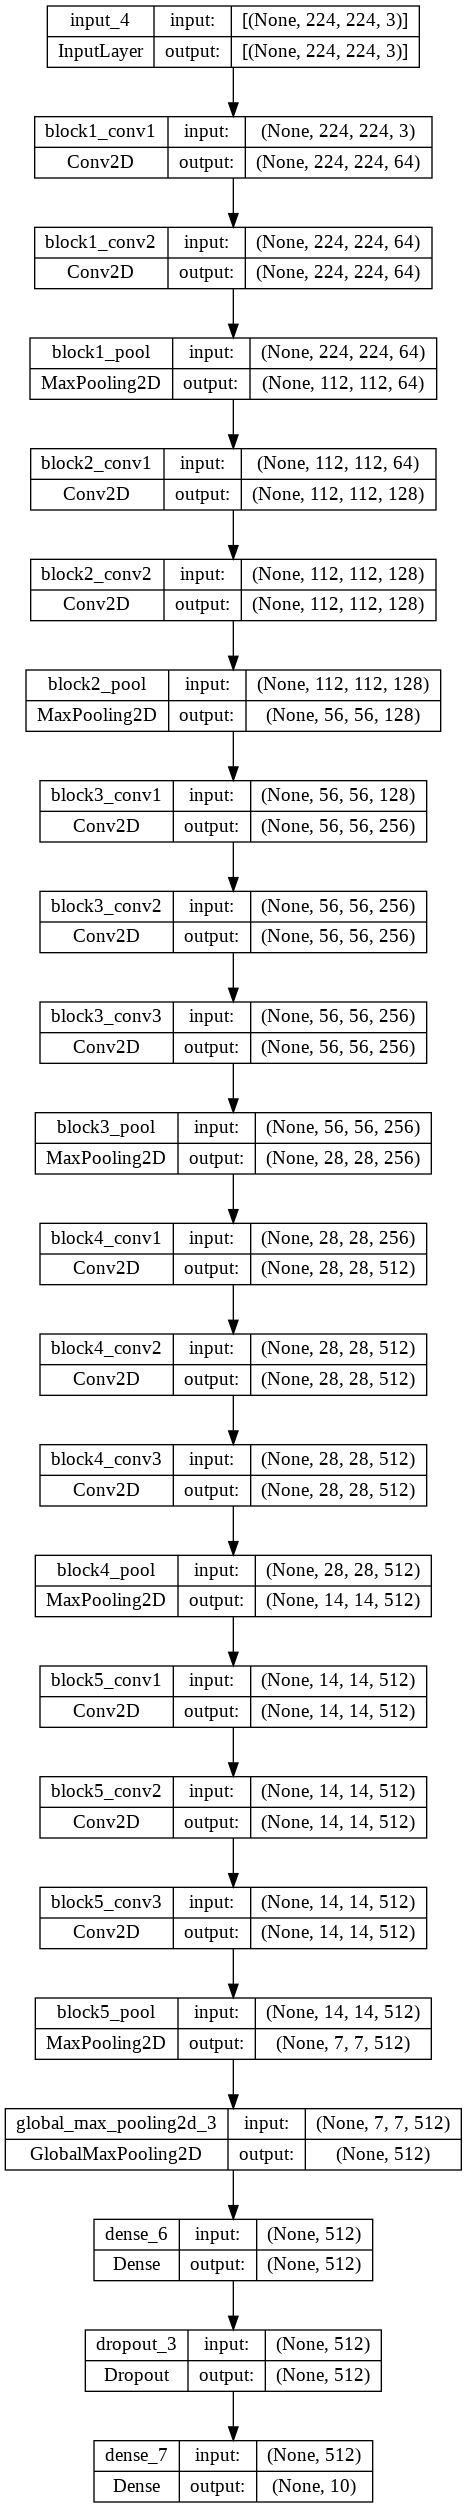

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='vgg16.png', show_shapes=True)

Saving Lidah Buaya030.jpg to Lidah Buaya030.jpg


1/1 [==============================] - 1s 647ms/step
[4, 6, 8, 7, 1, 5, 2, 0, 9, 3, 10]
Lidah Buaya : 99.98 %
Pandan : 0.02 %
Seledri : 0.0 %
Pepaya : 0.0 %
Jambu Biji : 0.0 %


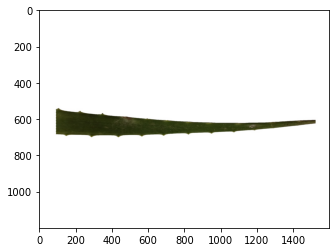

In [ ]:
from google.colab import files
from keras.models import load_model
from skimage.transform import resize

uploaded = files.upload()
model_path = '/content/gdrive/MyDrive/Artificial Intelligence/UAS/herbal_leaf_models_vgg16.h5'
model = load_model(model_path)

for fn in uploaded.keys():
  path = fn
  new_image = plt.imread(path)
  img = plt.imshow(new_image)
  
  resize_img = resize(new_image, (224,224,3))
  prediction = model.predict(np.array([resize_img]))
  
  list_index = [0,1,2,3,4,5,6,7,8,9,10]
  x = prediction

  for i in range(10):
    for j in range(10):
      if x[0][list_index[i]] > x[0][list_index[j]]:
        temp = list_index[i]
        list_index[i] = list_index[j]
        list_index[j] = temp
  print(list_index)

  for i in range(5):
    print(class_names[list_index[i]], ':', round(prediction[0][list_index[i]] * 100,2), '%')      